Imports

In [12]:
from ROOT import TFile,TTree,TCanvas,TH1F, gStyle, TLatex, gPad, TLegend, TLorentzVector, TH2F, TLine, TF1, TBox, RDataFrame, TPad, TF2, TChain
import ROOT
import numpy as np
%run ../../dihadron_toolkit/sideband_tools.ipynb


Load up some basic plot settings and TLatex 



In [3]:
gStyle.SetOptStat(0)
gStyle.SetHistLineWidth(2)
gStyle.SetTitleXSize(0.045)
gStyle.SetTitleYSize(0.035)
gStyle.SetTitleXOffset(1)
gStyle.SetTitleYOffset(1.2)
gStyle.SetPalette(55)
gStyle.SetNumberContours(50)

latex=TLatex()
latex.SetTextSize(0.03)

biglatex=TLatex()
biglatex.SetTextSize(0.045)

smalllatex=TLatex()
smalllatex.SetTextSize(0.022)

Create an RDataFrame by importing the root files from the analysis

In [4]:
ROOT.EnableImplicitMT(32)
#d = RDataFrame("tree_postprocess", {"../../../data/fall2018-torus-1-v1-nSidis/june3_*.root",
#                                          "../../../data/fall2018-torus+1-v1-nSidis/june3_*.root",
#                                          "../../../data/spring2019-torus-1-v1-nSidis/june3_*.root"})
d = RDataFrame("tree_postprocess", "/volatile/clas12/users/gmat/clas12analysis.sidis.data/rg-a/july14/july14*.root")

Define the polarizations and errors for each dataset

In [7]:
pol=np.array([0.8592,0.8922,0.8453])
polerr=np.array([0.01290,0.02509,0.01474])

Define cuts for the asymmetry plots

In [8]:
beta_cut = "abs(beta1-1)< 0.1 && abs(beta2-1) < 0.1"
sideband_cut = "Mdiphoton > 0.17 && Mdiphoton < 0.4"
signal_cut = "Mdiphoton > 0.108 && Mdiphoton < 0.160"

Define bins for {Mh , x , z} asymmetry

In [9]:
Mhbins = np.linspace(0.3,1.3,7)
xbins = np.array([0.1,0.13,0.16,0.19,0.235,0.3,0.5])
zbins = np.array([0.35,0.43,0.49,0.55,0.62,0.7,0.83])

Get Mgg plots for each {Mh, x, z} bin range

In [10]:
h_total_Mh = get_asym_plots(d,[beta_cut],"Mdihadron",Mhbins,100,0.08,0.4)
h_total_x = get_asym_plots(d,[beta_cut],"x",xbins,100,0.08,0.4)
h_total_z = get_asym_plots(d,[beta_cut],"z",zbins,100,0.08,0.4)

Get (phiH, phiR) plots for each {Mh , x , z} binning

In [13]:
h_asym_Mh = gethists_A_LU(d,[beta_cut],"Mdihadron",Mhbins,8,8,[0.108,0.160],[0.170,0.4])
h_asym_x = gethists_A_LU(d,[beta_cut],"x",xbins,8,8,[0.108,0.160],[0.170,0.4])
h_asym_z = gethists_A_LU(d,[beta_cut],"z",zbins,8,8,[0.108,0.160],[0.170,0.4])

Prepare Mgg plots for plotting (gets fit and residual plot)

In [14]:
%%time
fittype = "gaus(0)+pol4(3)"
fitpars = 8

f_total_Mh,res_total_Mh = process_Mgg(h_total_Mh,fittype,fitpars,0.08,0.4)
f_total_x,res_total_x = process_Mgg(h_total_x,fittype,fitpars,0.08,0.4)
f_total_z,res_total_z = process_Mgg(h_total_z,fittype,fitpars,0.08,0.4)

CPU times: user 7min 5s, sys: 6.59 s, total: 7min 11s
Wall time: 34.2 s


Get purity "u" for each {Mh , x , z}

In [15]:
u_Mh = [get_u(3,h_total_Mh[i],f_total_Mh[i],fittype,[0.108,0.160]) for i in range(len(Mhbins)-1)]
u_x = [get_u(3,h_total_x[i],f_total_x[i],fittype,[0.108,0.160]) for i in range(len(xbins)-1)]
u_z = [get_u(3,h_total_z[i],f_total_z[i],fittype,[0.108,0.160]) for i in range(len(zbins)-1)]

For each {Mh, x, z} find the total weighted polarization (w/ error) for the signal+sideband region

This requires us to split the dataframes into three pieces

In [16]:
#chains = [TChain("tree_postprocess"),TChain("tree_postprocess"),TChain("tree_postprocess")]
#chains[0].Add("../../../data/fall2018-torus-1-v1-nSidis/june3_3.root")
#chains[1].Add("../../../data/fall2018-torus+1-v1-nSidis/june3_3.root")
#chains[2].Add("../../../data/spring2019-torus-1-v1-nSidis/june3_3.root")
chains = [TChain("tree_postprocess"),TChain("tree_postprocess"),TChain("tree_postprocess")]
chains[0].Add("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rg-a/july14/july14_0.root")
chains[1].Add("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rg-a/july14/july14_200.root")
chains[2].Add("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rg-a/july14/july14_350.root")
p_Mh = get_weighted_polarization(chains,"Mdihadron",Mhbins,pol,polerr,[beta_cut],[0.108,0.160],[0.170,0.4])
p_x = get_weighted_polarization(chains,"x",xbins,pol,polerr,[beta_cut],[0.108,0.160],[0.170,0.4])
p_z = get_weighted_polarization(chains,"z",zbins,pol,polerr,[beta_cut],[0.108,0.160],[0.170,0.4])

Mdihadron weighted polarization calculation complete
x weighted polarization calculation complete
z weighted polarization calculation complete


Get final asymmetry plots

In [17]:
asym_Mh = process_A_LU(u_Mh,h_asym_Mh,p_Mh)
asym_x = process_A_LU(u_x,h_asym_x,p_x)
asym_z = process_A_LU(u_z,h_asym_z,p_z)

In [18]:
print(p_Mh,"\n",p_x,"\n",p_z)

([0.8755504102096627, 0.8758274543874892, 0.8743691464821222, 0.8752621842496284, 0.8748152278177458, 0.8766011881188119], [0.040743891319554915, 0.040030617957928, 0.03357903043769374, 0.037462550299952865, 0.04581562445457338, 0.05776869701849808], [0.8732466830466831, 0.8756357645553423, 0.8747175339896859, 0.8755579102715466, 0.8742176844783714, 0.8759759590792838], [0.06301205329271878, 0.03517691328095476, 0.03115368389122957, 0.03425295433397757, 0.046876062760328456, 0.06486718565340927]) 
 ([0.8752761983471075, 0.8752195903829029, 0.874726517967782, 0.8746377870563673, 0.8755498858447488, 0.87392254812099], [0.039272671632946676, 0.040421330653769315, 0.04643783746166792, 0.042941453769235395, 0.044742874884483745, 0.04038637560550239], [0.8751817411402159, 0.8748040074557315, 0.8761046511627907, 0.8736752497225304, 0.8753720605355064, 0.8745046315789474], [0.03808914369610106, 0.04100600396477433, 0.04748883015354427, 0.04385539621803052, 0.04506551034946171, 0.04297507197243

Plot Mdiphoton distributions, fits, and residuals for helicity = +1 and -1

# 0. Define some useful parameters for later

In [19]:
sigbg_color = 2
sig_color = 8
bg_color = 9

sigbg_marker = 22
sig_marker = 20
bg_marker = 23

Mh_1a = [Mhbins, h_total_Mh, f_total_Mh, res_total_Mh, u_Mh, "M_{h} [GeV]"]
Mh_1b = [Mhbins,asym_Mh[0],asym_Mh[1],asym_Mh[2],asym_Mh[3],asym_Mh[4],asym_Mh[5],u_Mh,"M_{h} [GeV]"]
Mh_1c = [Mhbins,asym_Mh[4],asym_Mh[5],u_Mh,"M_{h} [GeV]"]

x_2a = [xbins, h_total_x, f_total_x, res_total_x, u_x, "x"]
x_2b = [xbins,asym_x[0],asym_x[1],asym_x[2],asym_x[3],asym_x[4],asym_x[5],u_x,"x"]
x_2c = [xbins,asym_x[4],asym_x[5],u_x,"x"]

z_3a = [zbins, h_total_z, f_total_z, res_total_z, u_z, "z"]
z_3b = [zbins,asym_z[0],asym_z[1],asym_z[2],asym_z[3],asym_z[4],asym_z[5],u_z,"z"]
z_3c = [zbins,asym_z[4],asym_z[5],u_z,"z"]

d_f18_0 = RDataFrame("tree_postprocess", "../../../data/fall2018-torus-1-v1-nSidis/may26_*.root")
d_f18_1 = RDataFrame("tree_postprocess","../../../data/fall2018-torus+1-v1-nSidis/may26_*.root")
d_s19_0 = RDataFrame("tree_postprocess","../../../data/spring2019-torus-1-v1-nSidis/may26_*.root")

d = [d_f18_0, d_f18_1, d_s19_0]



# 1: Mdihadron binning
---
## 1a: Purity fits 

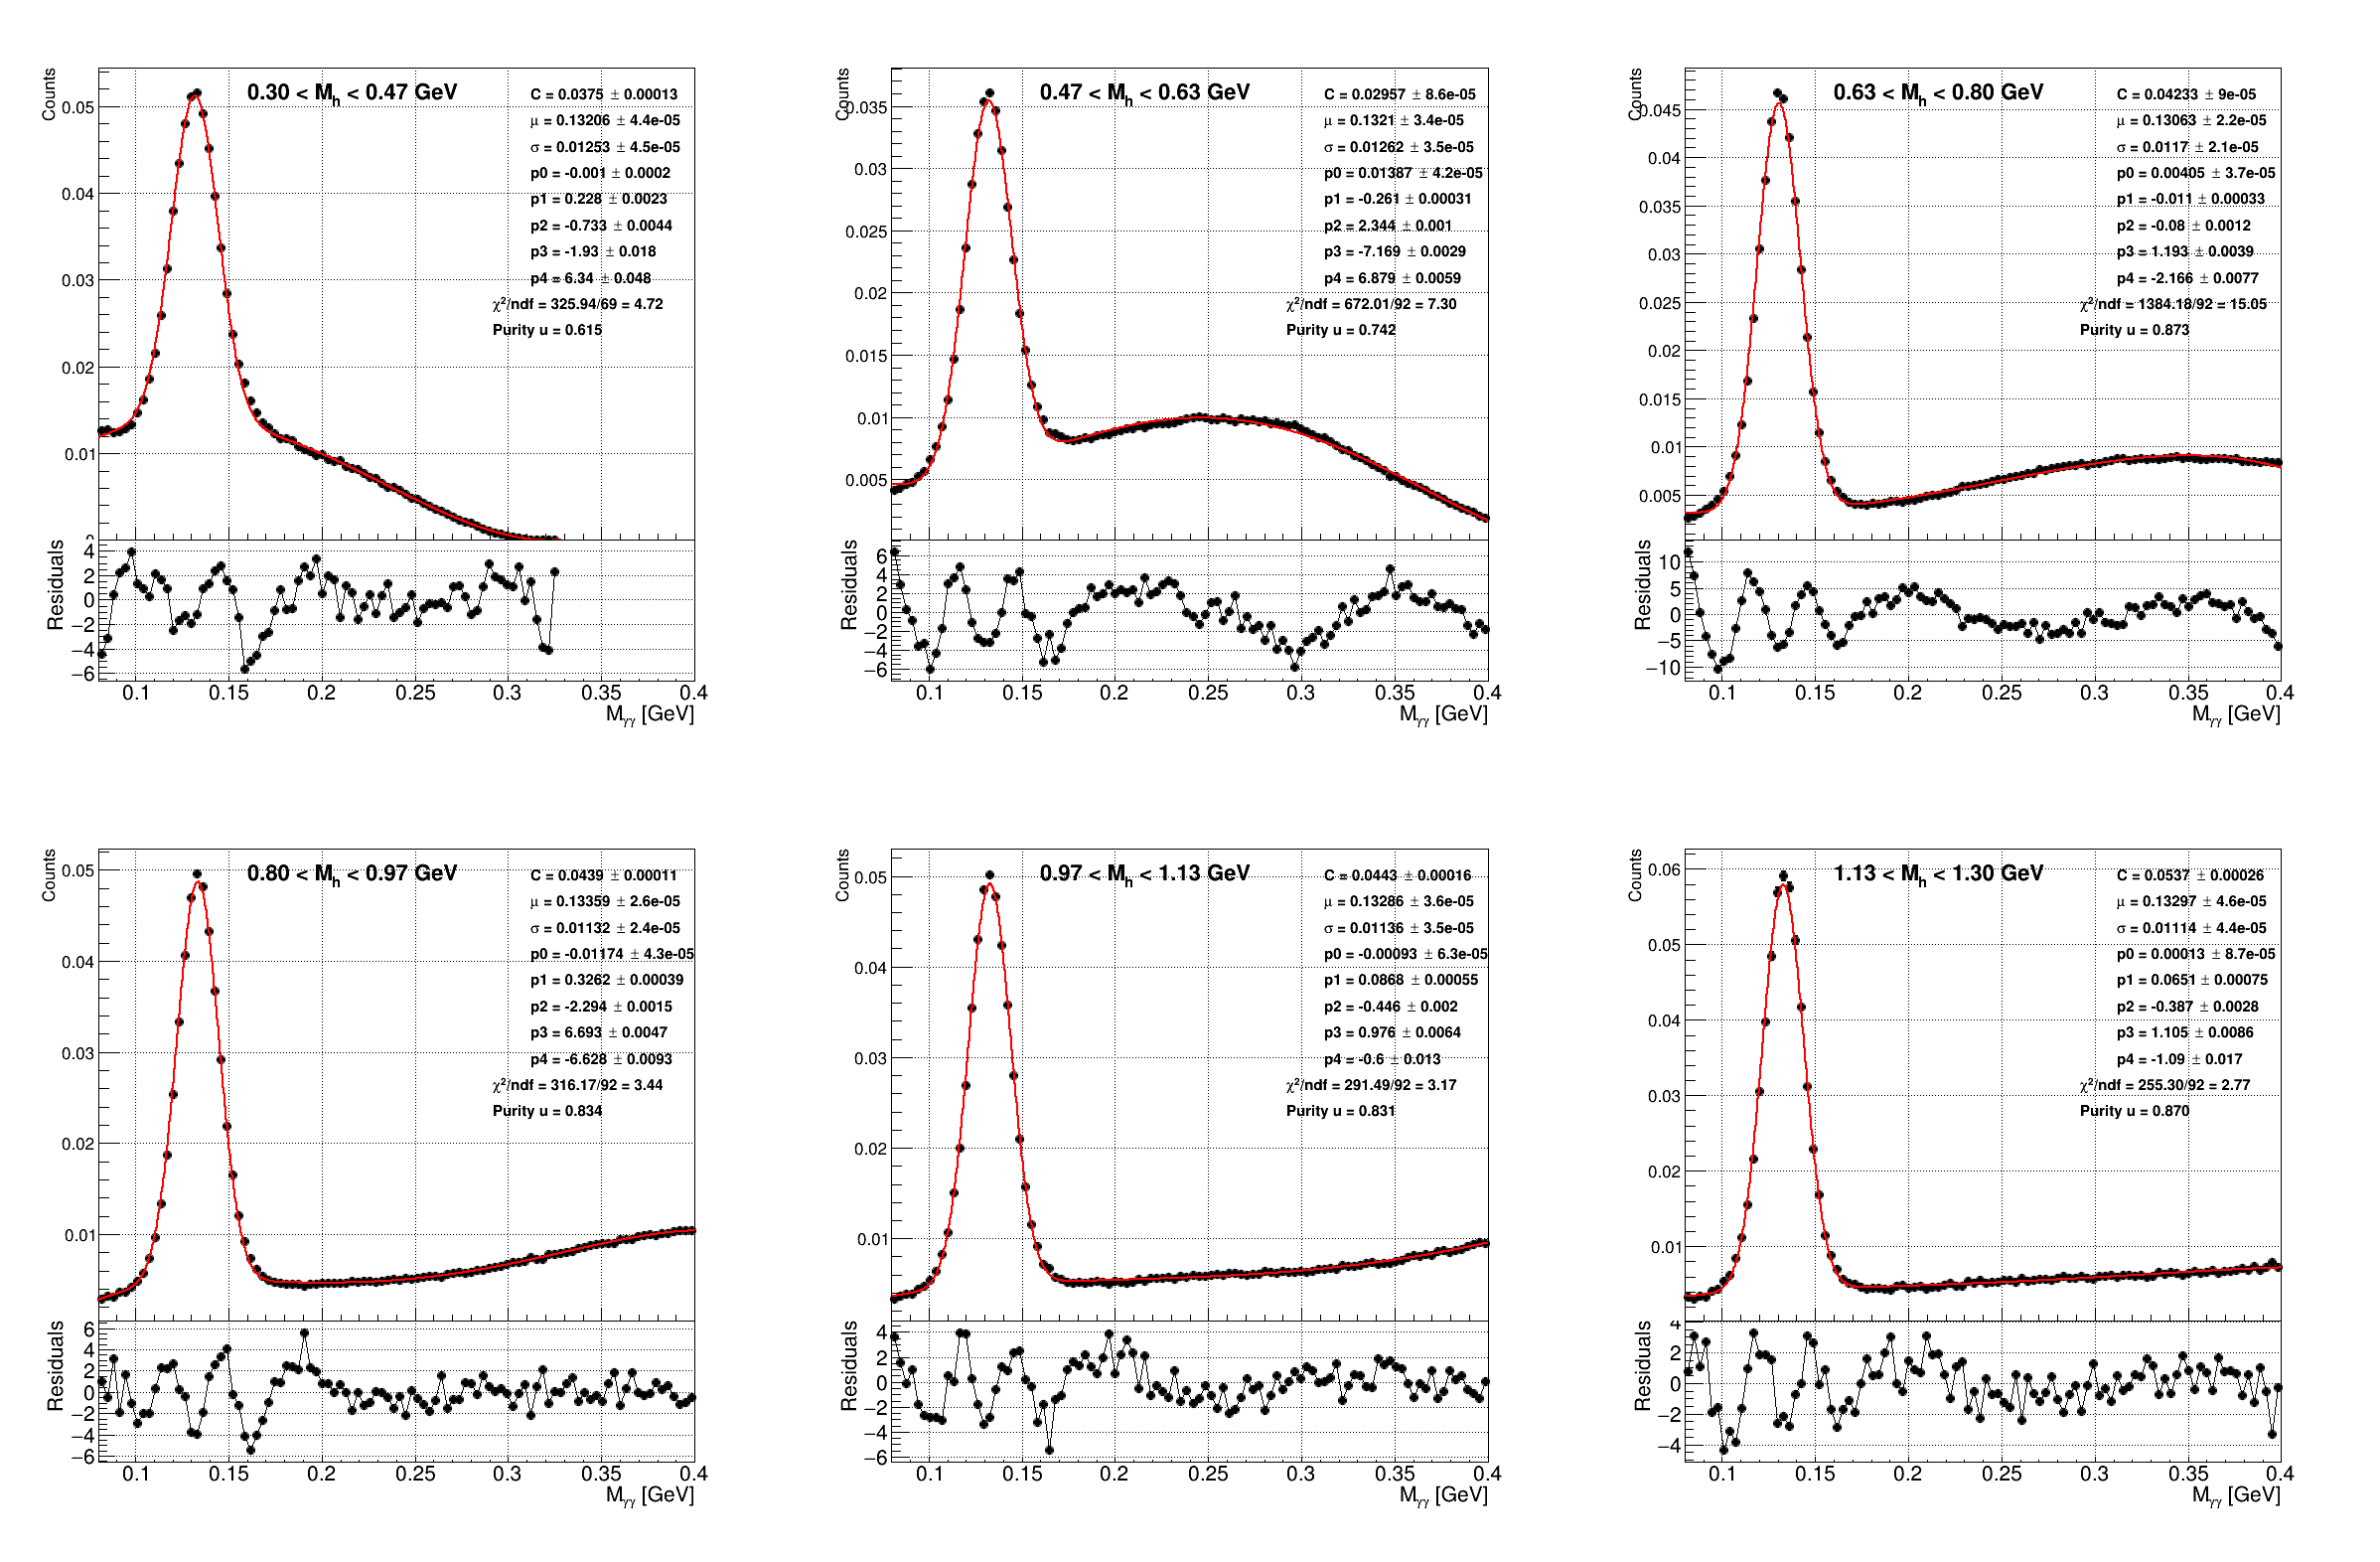

In [20]:
bins, h_total, f_total, res_total, u ,plotstr = Mh_1a

c = TCanvas("c","c",2400,1600)
c.Divide(3,2)
for i in range(6):
    c.cd(i+1)
    
    # =========== Draw fit =========== #
    p1 = TPad("p1{}".format(i),"p1{}".format(i),0,0.3,1,1)
    p1.Draw()
    p1.cd()
    p1.SetBottomMargin(0)
    h_total[i].Draw("E1")
    f_total[i].Draw("same")
    gPad.SetGrid()
    biglatex.DrawLatexNDC(0.3,0.84,"{:.2f} < ".format(bins[i]) + "{} <".format("M_{h}")+" {:.2f} GeV".format(bins[i+1]))
    
    u = get_u(3,h_total[i],f_total[i],fittype,[0.108,0.160])
    drawFitLatex(latex,0.68,0.84,0.05,f_total[i],fittype,u)
    c.cd(i+1)
    # =========== Draw residuals =========== #
    p2 = TPad("p2{}".format(i),"p2{}".format(i),0,0.05,1,0.3)
    p2.Draw()
    p2.cd()
    p2.SetTopMargin(0)
    p2.SetBottomMargin(0.25)
    res_total[i].Draw("APL")
    gPad.SetGrid()
c.Draw()

## 1b: Asymmetry plots (signal,  bg, signal+bg)

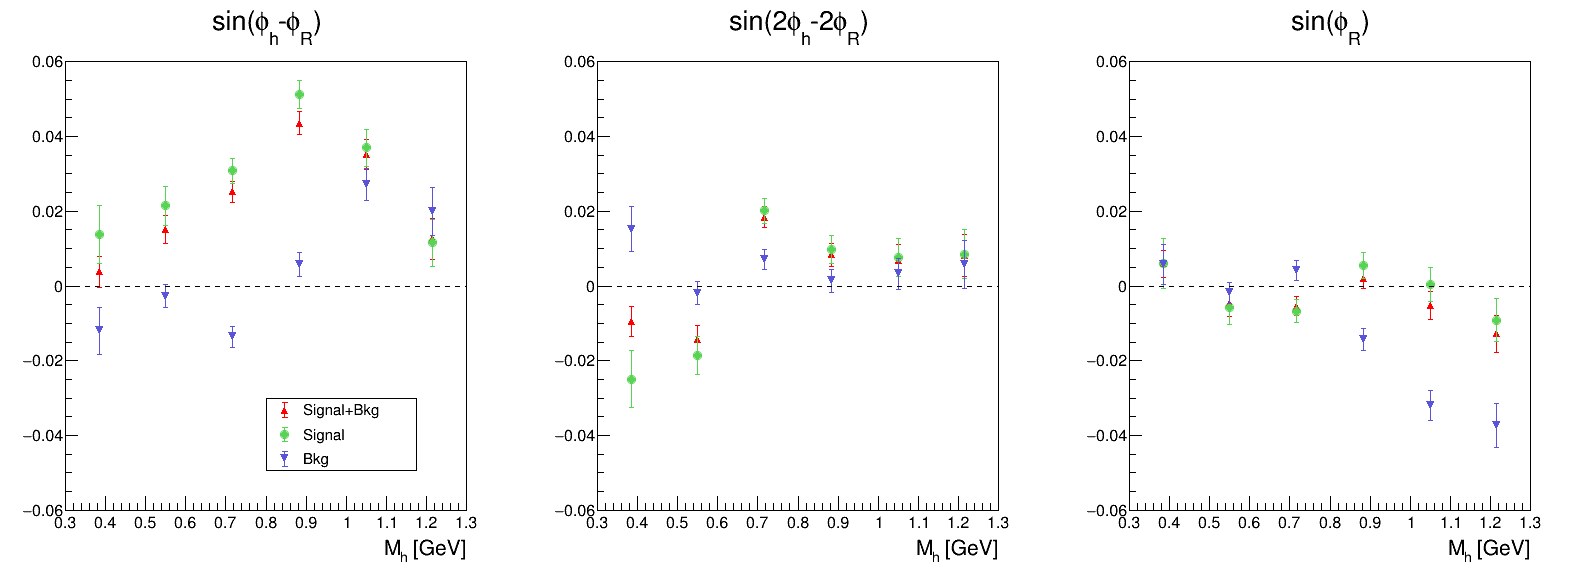

In [21]:
bins, fitpars_sigbg, errors_sigbg,fitpars_bg,errors_bg,fitpars_sig,errors_sig, u, plotstr = Mh_1b

idx_mods = [1,0,3]
ranges = [[-0.06,0.06],[-0.06,0.06],[-0.06,0.06]]

c = TCanvas("c","c",1600,600)
c.Divide(3,1)
tges_sigbg=get_asym_graph(bins,fitpars_sigbg,errors_sigbg,sigbg_color,sigbg_marker,ranges,idx_mods,plotstr)
tges_sig=get_asym_graph(bins,fitpars_sig,errors_sig,sig_color,sig_marker,ranges,idx_mods,plotstr)
tges_bg=get_asym_graph(bins,fitpars_bg,errors_bg,bg_color,bg_marker,ranges,idx_mods,plotstr)

line=TLine(bins[0],0,bins[-1],0)
line.SetLineStyle(7)

for i in range(len(idx_mods)):
    c.cd(i+1)
    
    idx = idx_mods[i]
    modulation_name = mods[idx]
    tges_sigbg[i].Draw("APE")
    tges_sig[i].Draw("PE same")
    tges_bg[i].Draw("PE same")
    if(i==0):
        legend=TLegend(0.5,0.17,0.8,0.3)
        legend.AddEntry(tges_sigbg[i],"Signal+Bkg","PE")
        legend.AddEntry(tges_sig[i],"Signal","PE")
        legend.AddEntry(tges_bg[i],"Bkg","PE")
        legend.Draw("same")
    line.Draw("same")
c.Draw()

## 1c. Asymmetry plots (Sig only)

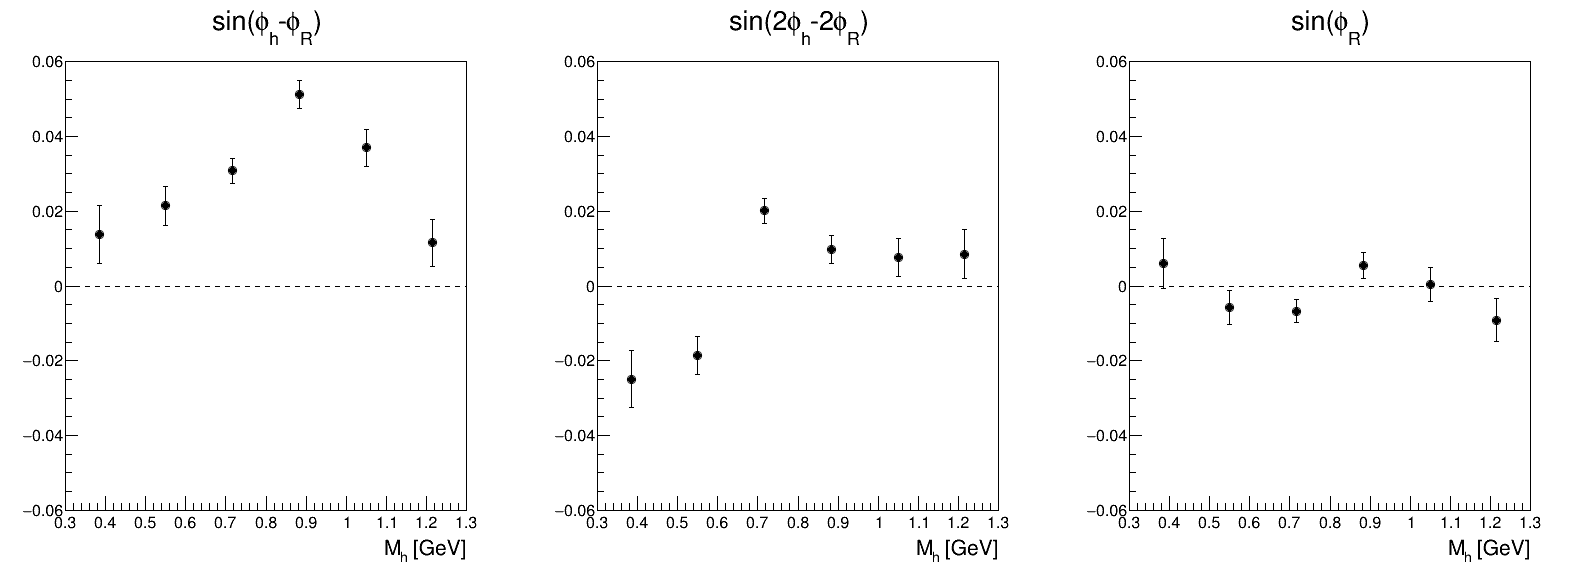

In [22]:
bins, fitpars_sig,errors_sig, u, plotstr = Mh_1c

idx_mods = [1,0,3]
ranges = [[-0.06,0.06],[-0.06,0.06],[-0.06,0.06]]

c = TCanvas("c","c",1600,600)
c.Divide(3,1)
tges_sig=get_asym_graph(bins,fitpars_sig,errors_sig,1,20,ranges,idx_mods,plotstr)

line=TLine(bins[0],0,bins[-1],0)
line.SetLineStyle(7)

for i in range(len(idx_mods)):
    c.cd(i+1)
    
    idx = idx_mods[i]
    modulation_name = mods[idx]
    tges_sig[i].Draw("APE same")
    
    line.Draw("same")
c.Draw()

# 2: x binning
---
## 2a: Purity fits

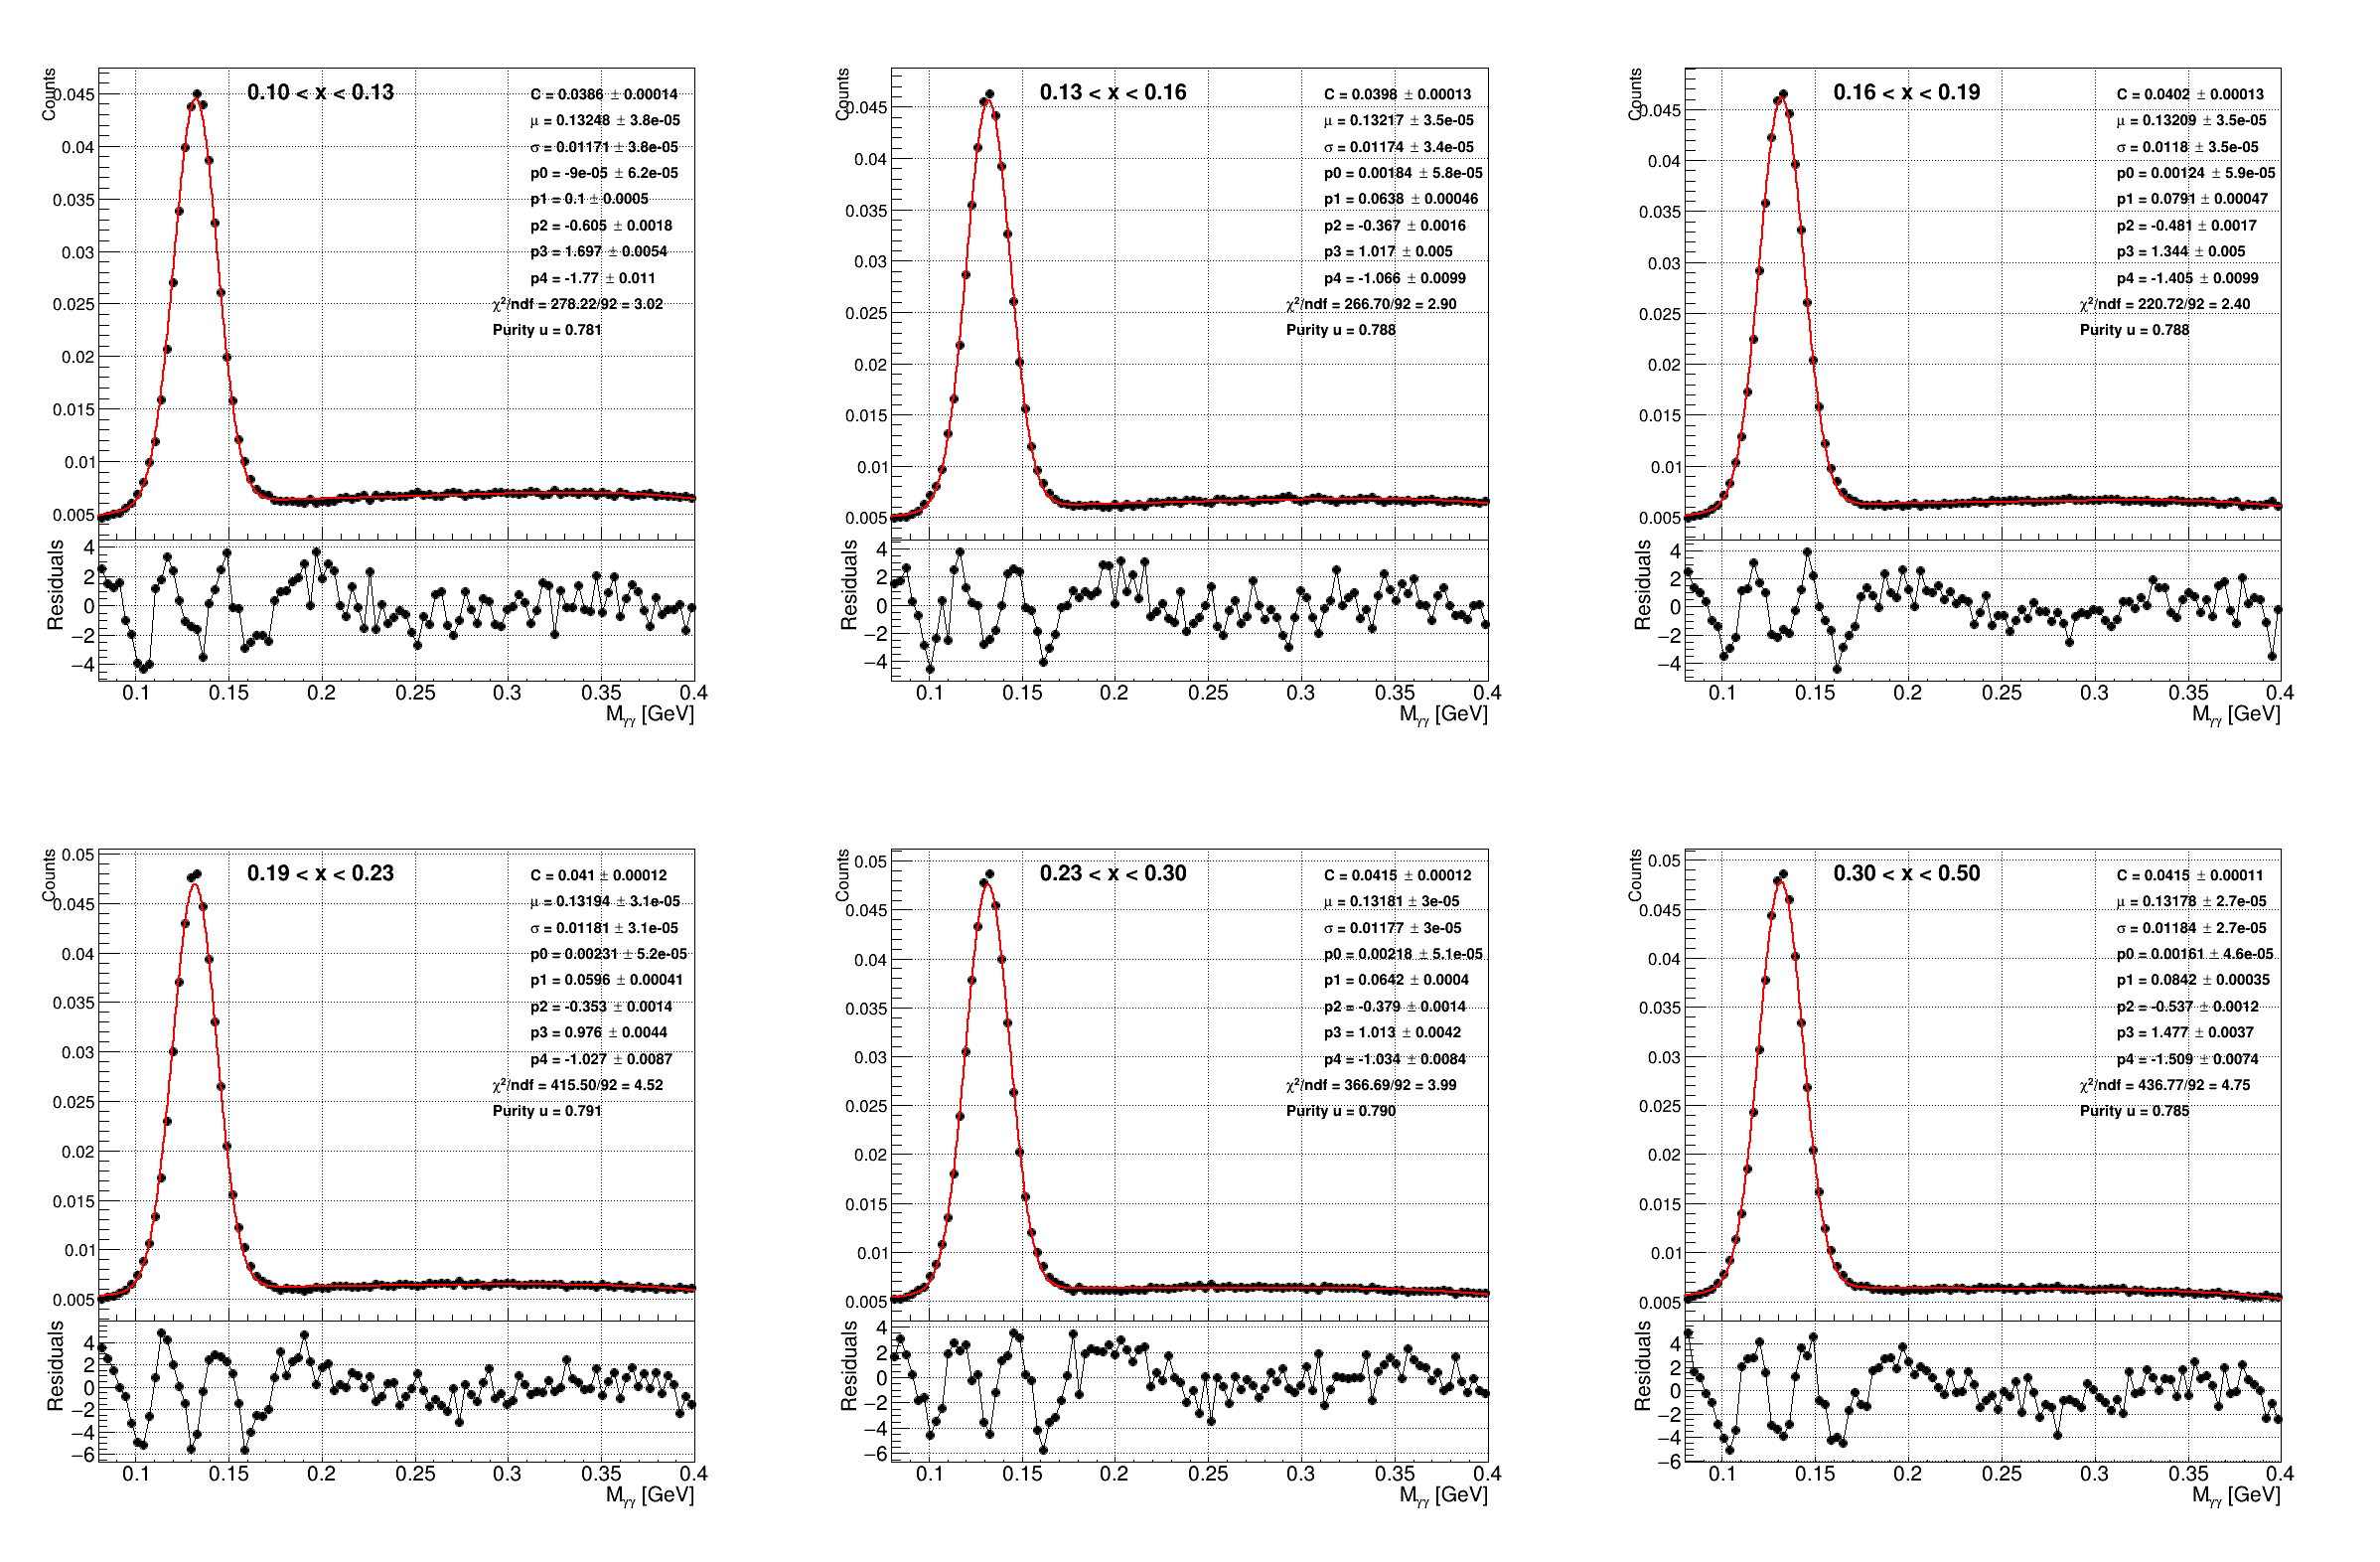

In [23]:
bins, h_total, f_total, res_total, u ,plotstr = x_2a

c = TCanvas("c","c",2400,1600)
c.Divide(3,2)
for i in range(6):
    c.cd(i+1)
    
    # =========== Draw fit =========== #
    p1 = TPad("p1{}".format(i),"p1{}".format(i),0,0.3,1,1)
    p1.Draw()
    p1.cd()
    p1.SetBottomMargin(0)
    h_total[i].Draw("E1")
    f_total[i].Draw("same")
    gPad.SetGrid()
    biglatex.DrawLatexNDC(0.3,0.84,"{:.2f} < ".format(bins[i]) + "{} <".format(plotstr)+" {:.2f}".format(bins[i+1]))
    
    u = get_u(3,h_total[i],f_total[i],fittype,[0.108,0.160])
    drawFitLatex(latex,0.68,0.84,0.05,f_total[i],fittype,u)
    c.cd(i+1)
    # =========== Draw residuals =========== #
    p2 = TPad("p2{}".format(i),"p2{}".format(i),0,0.05,1,0.3)
    p2.Draw()
    p2.cd()
    p2.SetTopMargin(0)
    p2.SetBottomMargin(0.25)
    res_total[i].Draw("APL")
    gPad.SetGrid()
c.Draw()

## 2b: Asymmetry plots (signal,  bg, signal+bg)

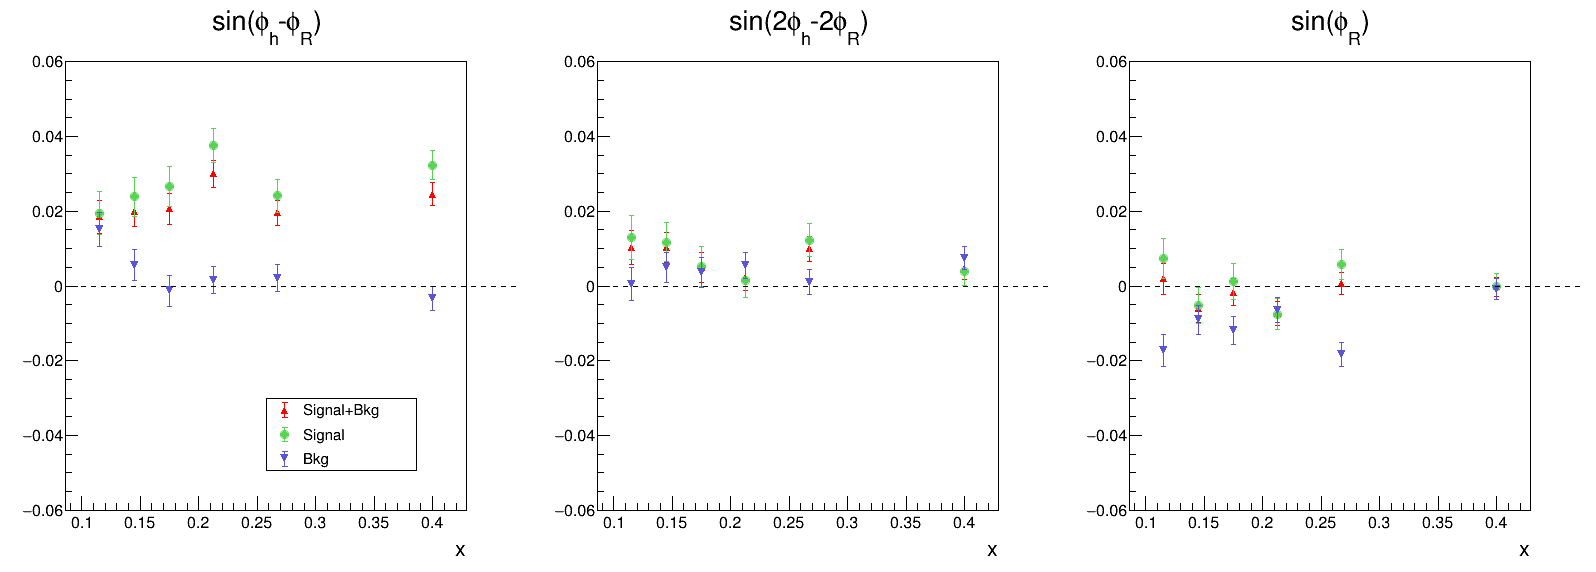

In [24]:
bins, fitpars_sigbg, errors_sigbg,fitpars_bg,errors_bg,fitpars_sig,errors_sig, u, plotstr = x_2b

idx_mods = [1,0,3]
ranges = [[-0.06,0.06],[-0.06,0.06],[-0.06,0.06]]

c = TCanvas("c","c",1600,600)
c.Divide(3,1)
tges_sigbg=get_asym_graph(bins,fitpars_sigbg,errors_sigbg,sigbg_color,sigbg_marker,ranges,idx_mods,plotstr)
tges_sig=get_asym_graph(bins,fitpars_sig,errors_sig,sig_color,sig_marker,ranges,idx_mods,plotstr)
tges_bg=get_asym_graph(bins,fitpars_bg,errors_bg,bg_color,bg_marker,ranges,idx_mods,plotstr)

line=TLine(bins[0],0,bins[-1],0)
line.SetLineStyle(7)

for i in range(len(idx_mods)):
    c.cd(i+1)
    
    idx = idx_mods[i]
    modulation_name = mods[idx]
    tges_sigbg[i].Draw("APE")
    tges_sig[i].Draw("PE same")
    tges_bg[i].Draw("PE same")
    if(i==0):
        legend=TLegend(0.5,0.17,0.8,0.3)
        legend.AddEntry(tges_sigbg[i],"Signal+Bkg","PE")
        legend.AddEntry(tges_sig[i],"Signal","PE")
        legend.AddEntry(tges_bg[i],"Bkg","PE")
        legend.Draw("same")
    line.Draw("same")
c.Draw()

## 2c: Asymmetry plots (sig only)

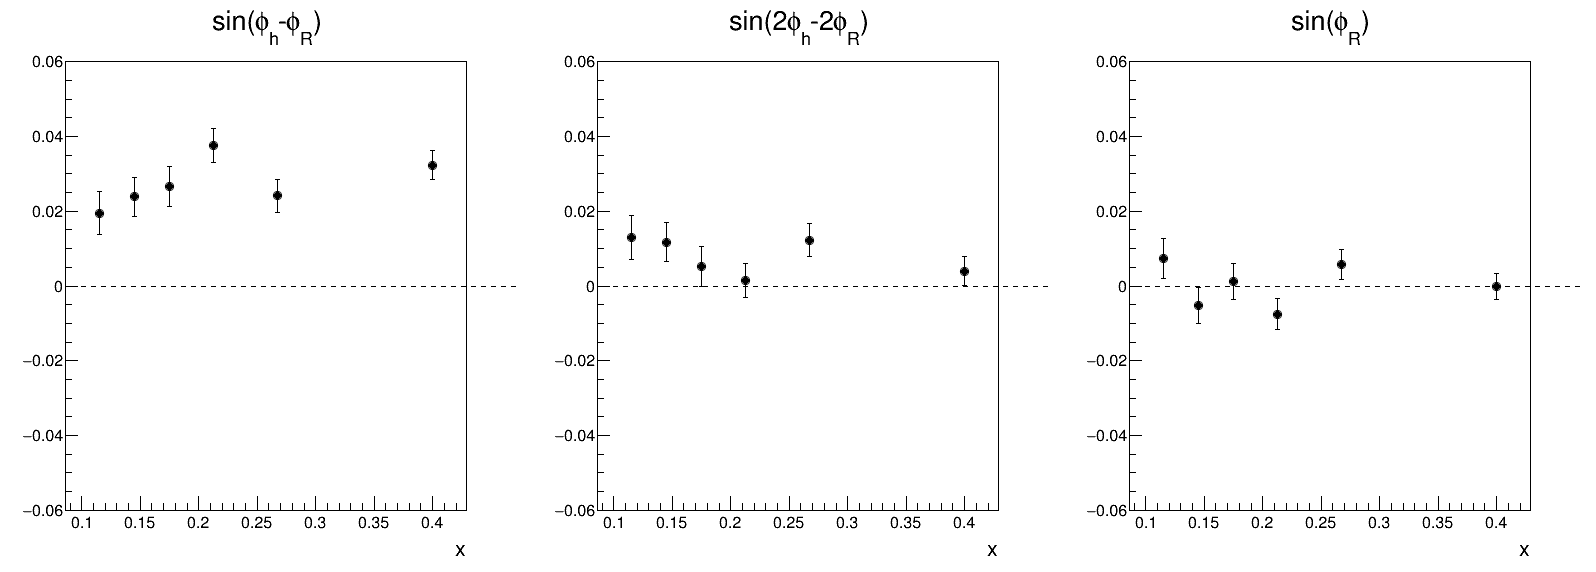

In [25]:
bins, fitpars_sig,errors_sig, u, plotstr = x_2c

idx_mods = [1,0,3]
ranges = [[-0.06,0.06],[-0.06,0.06],[-0.06,0.06]]

c = TCanvas("c","c",1600,600)
c.Divide(3,1)
tges_sig=get_asym_graph(bins,fitpars_sig,errors_sig,1,20,ranges,idx_mods,plotstr)

line=TLine(bins[0],0,bins[-1],0)
line.SetLineStyle(7)

for i in range(len(idx_mods)):
    c.cd(i+1)
    
    idx = idx_mods[i]
    modulation_name = mods[idx]
    tges_sig[i].Draw("APE same")
    
    line.Draw("same")
c.Draw()

# 3: z binning
---
## 3a: Purity fits

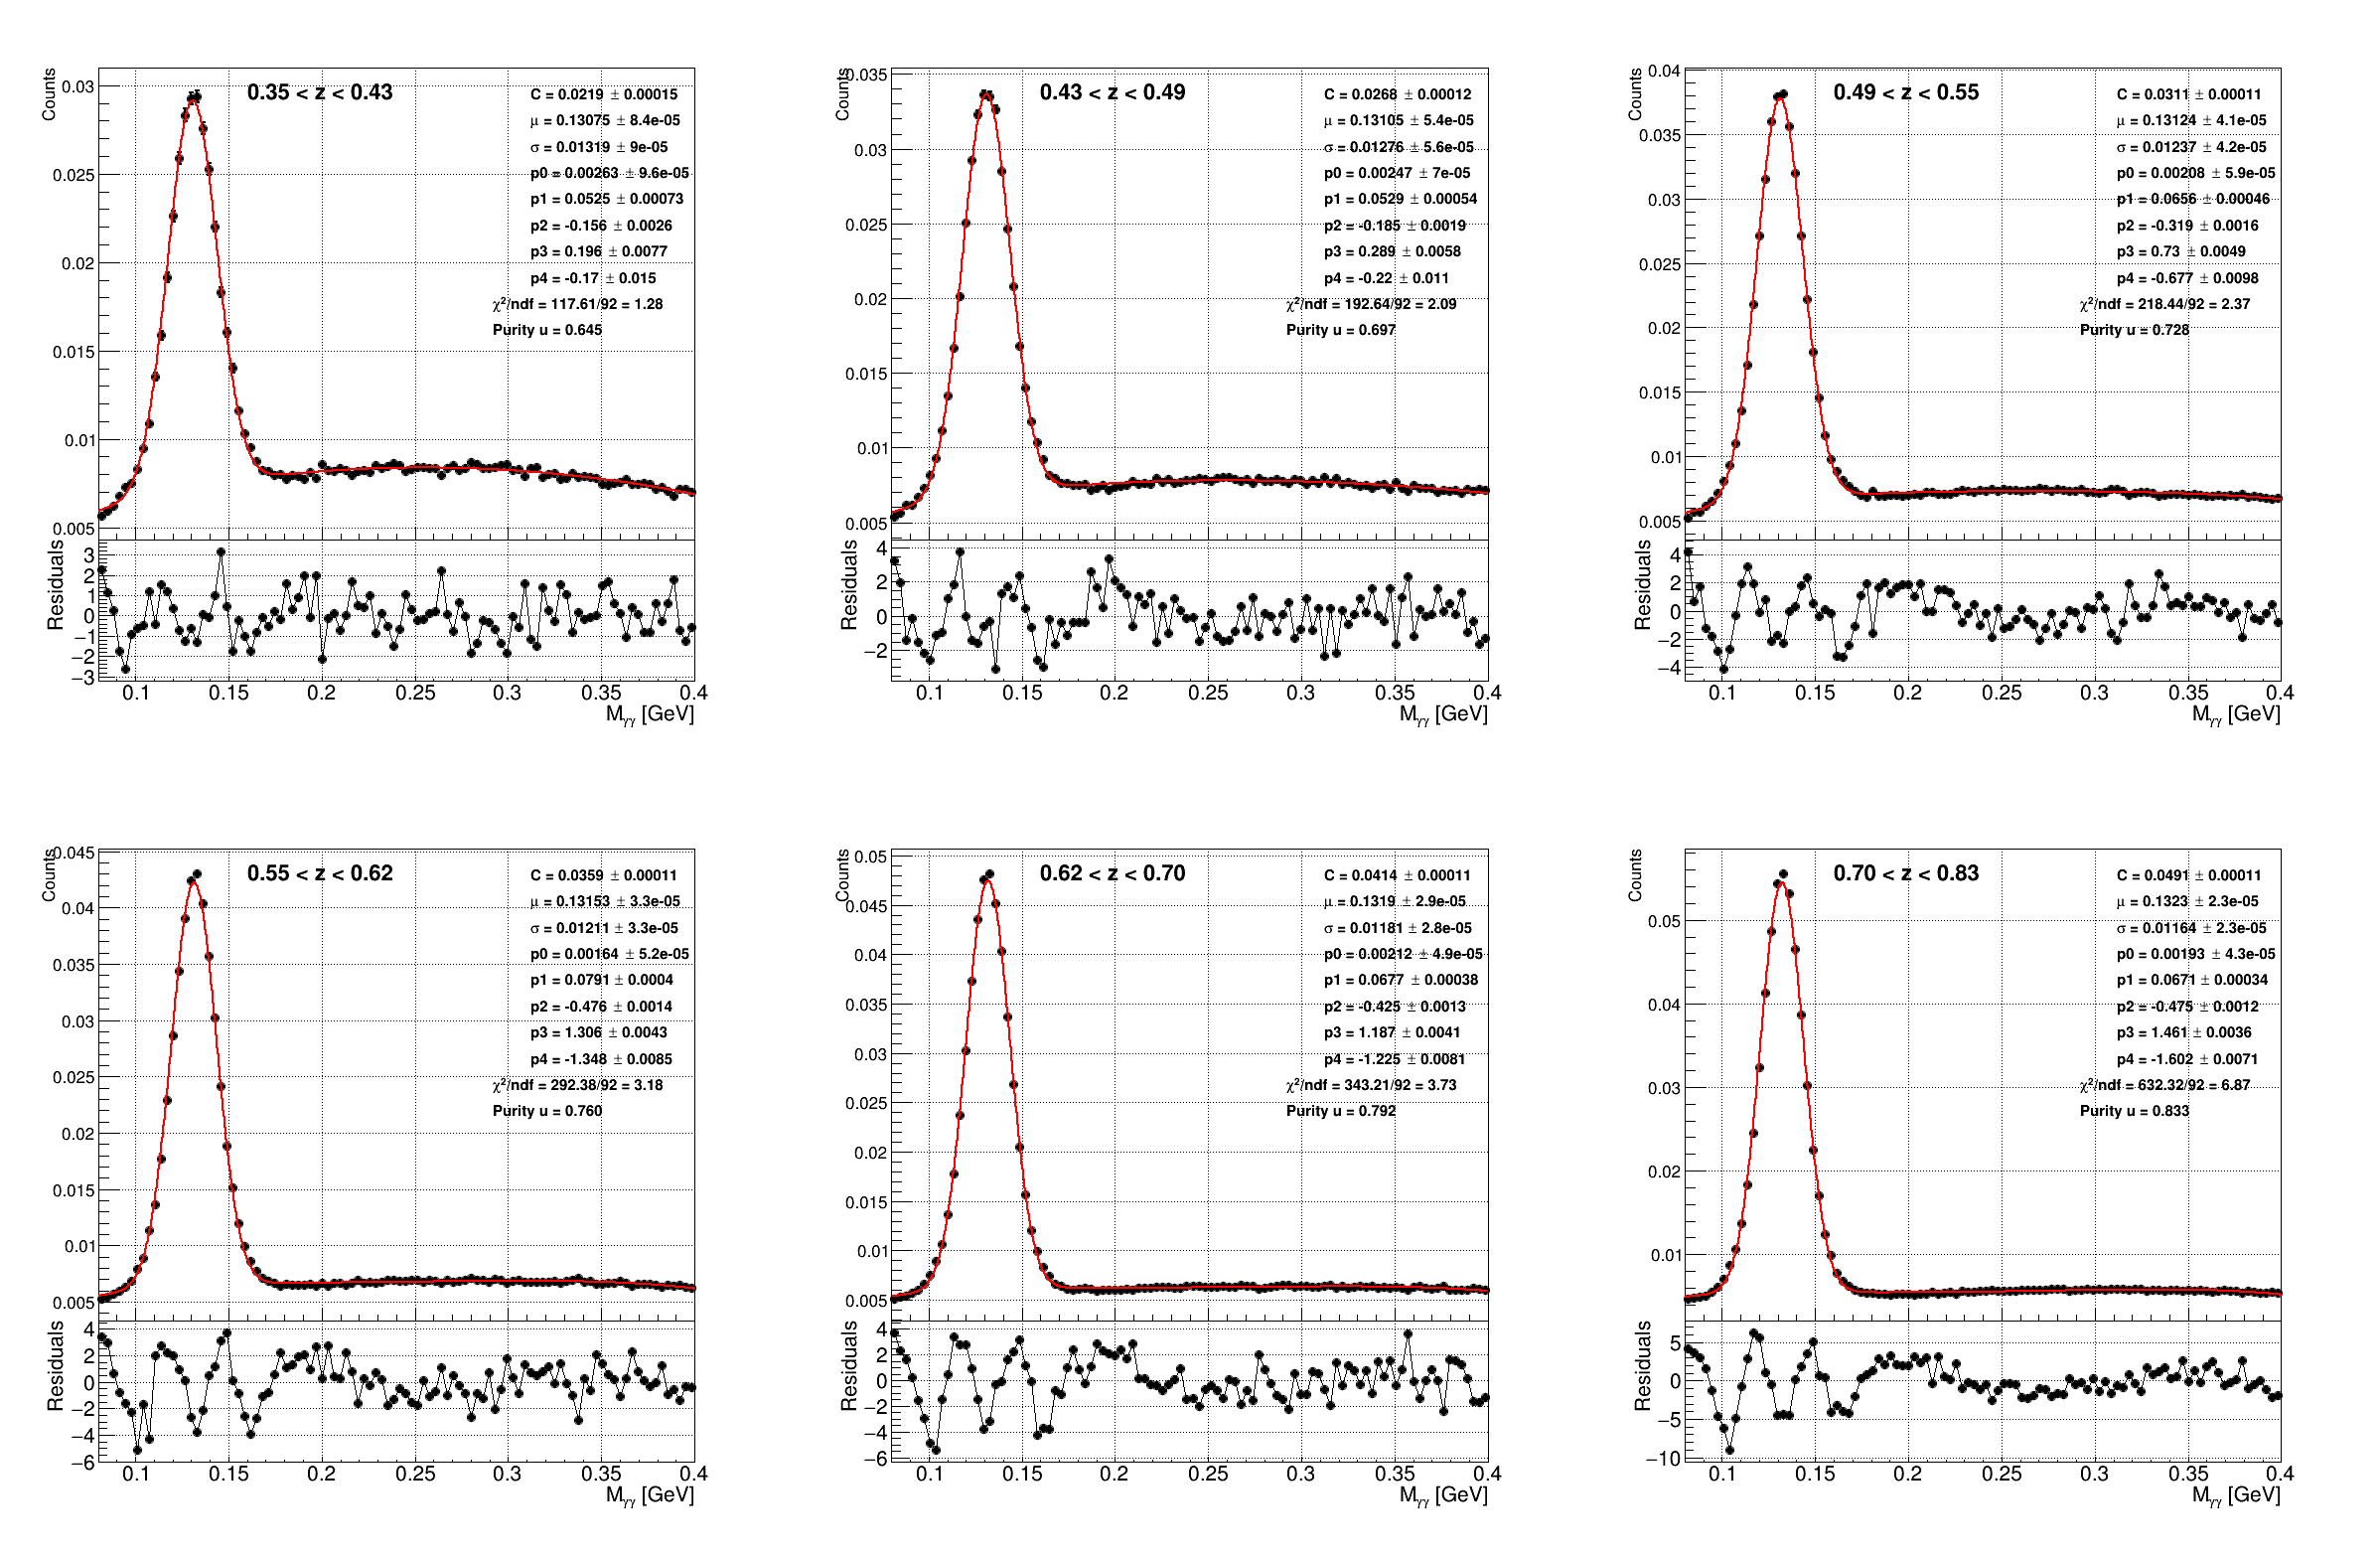

In [26]:
bins, h_total, f_total, res_total, u ,plotstr = z_3a

c = TCanvas("c","c",2400,1600)
c.Divide(3,2)
for i in range(6):
    c.cd(i+1)
    
    # =========== Draw fit =========== #
    p1 = TPad("p1{}".format(i),"p1{}".format(i),0,0.3,1,1)
    p1.Draw()
    p1.cd()
    p1.SetBottomMargin(0)
    h_total[i].Draw("E1")
    f_total[i].Draw("same")
    gPad.SetGrid()
    biglatex.DrawLatexNDC(0.3,0.84,"{:.2f} < ".format(bins[i]) + "{} <".format(plotstr)+" {:.2f}".format(bins[i+1]))
    
    u = get_u(3,h_total[i],f_total[i],fittype,[0.108,0.160])
    drawFitLatex(latex,0.68,0.84,0.05,f_total[i],fittype,u)
    c.cd(i+1)
    # =========== Draw residuals =========== #
    p2 = TPad("p2{}".format(i),"p2{}".format(i),0,0.05,1,0.3)
    p2.Draw()
    p2.cd()
    p2.SetTopMargin(0)
    p2.SetBottomMargin(0.25)
    res_total[i].Draw("APL")
    gPad.SetGrid()
c.Draw()

## 3b: Asymmetry plots (signal,  bg, signal+bg)

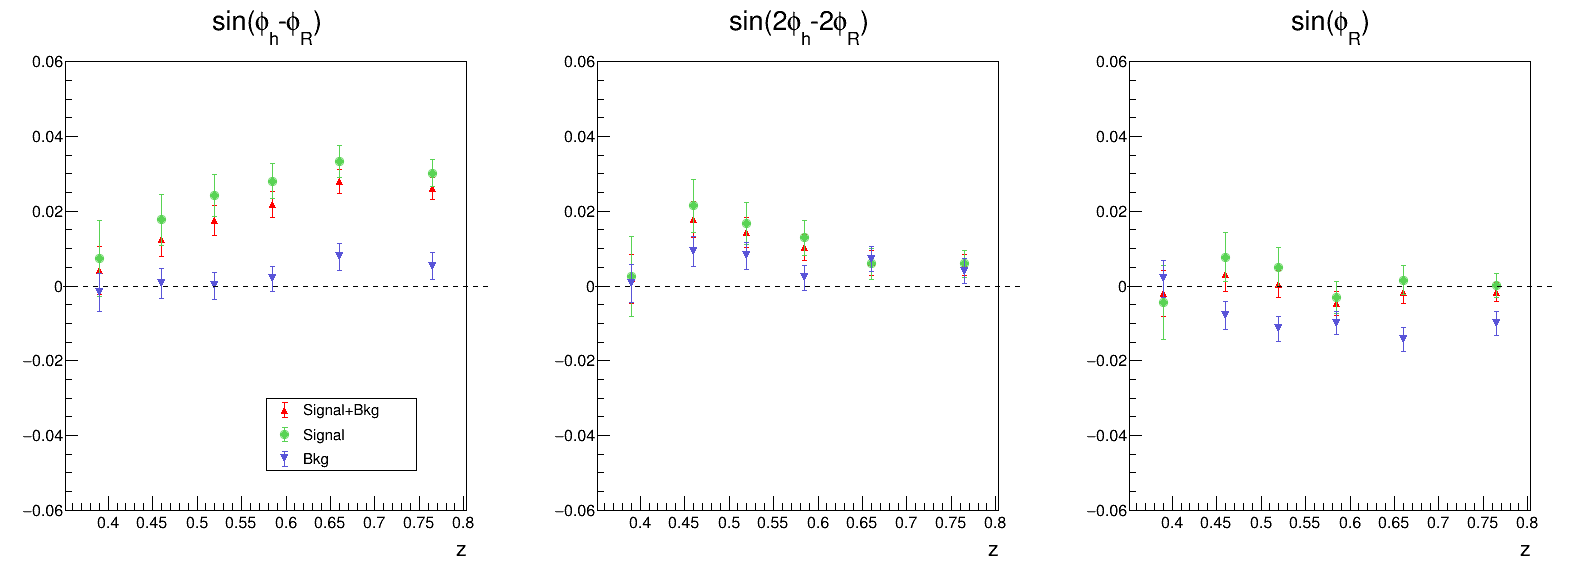

In [27]:
bins, fitpars_sigbg, errors_sigbg,fitpars_bg,errors_bg,fitpars_sig,errors_sig, u, plotstr = z_3b

idx_mods = [1,0,3]
ranges = [[-0.06,0.06],[-0.06,0.06],[-0.06,0.06]]

c = TCanvas("c","c",1600,600)
c.Divide(3,1)
tges_sigbg=get_asym_graph(bins,fitpars_sigbg,errors_sigbg,sigbg_color,sigbg_marker,ranges,idx_mods,plotstr)
tges_sig=get_asym_graph(bins,fitpars_sig,errors_sig,sig_color,sig_marker,ranges,idx_mods,plotstr)
tges_bg=get_asym_graph(bins,fitpars_bg,errors_bg,bg_color,bg_marker,ranges,idx_mods,plotstr)

line=TLine(bins[0],0,bins[-1],0)
line.SetLineStyle(7)

for i in range(len(idx_mods)):
    c.cd(i+1)
    
    idx = idx_mods[i]
    modulation_name = mods[idx]
    tges_sigbg[i].Draw("APE")
    tges_sig[i].Draw("PE same")
    tges_bg[i].Draw("PE same")
    if(i==0):
        legend=TLegend(0.5,0.17,0.8,0.3)
        legend.AddEntry(tges_sigbg[i],"Signal+Bkg","PE")
        legend.AddEntry(tges_sig[i],"Signal","PE")
        legend.AddEntry(tges_bg[i],"Bkg","PE")
        legend.Draw("same")
    line.Draw("same")
c.Draw()

## 3c: Asymmetry plots (sig only)

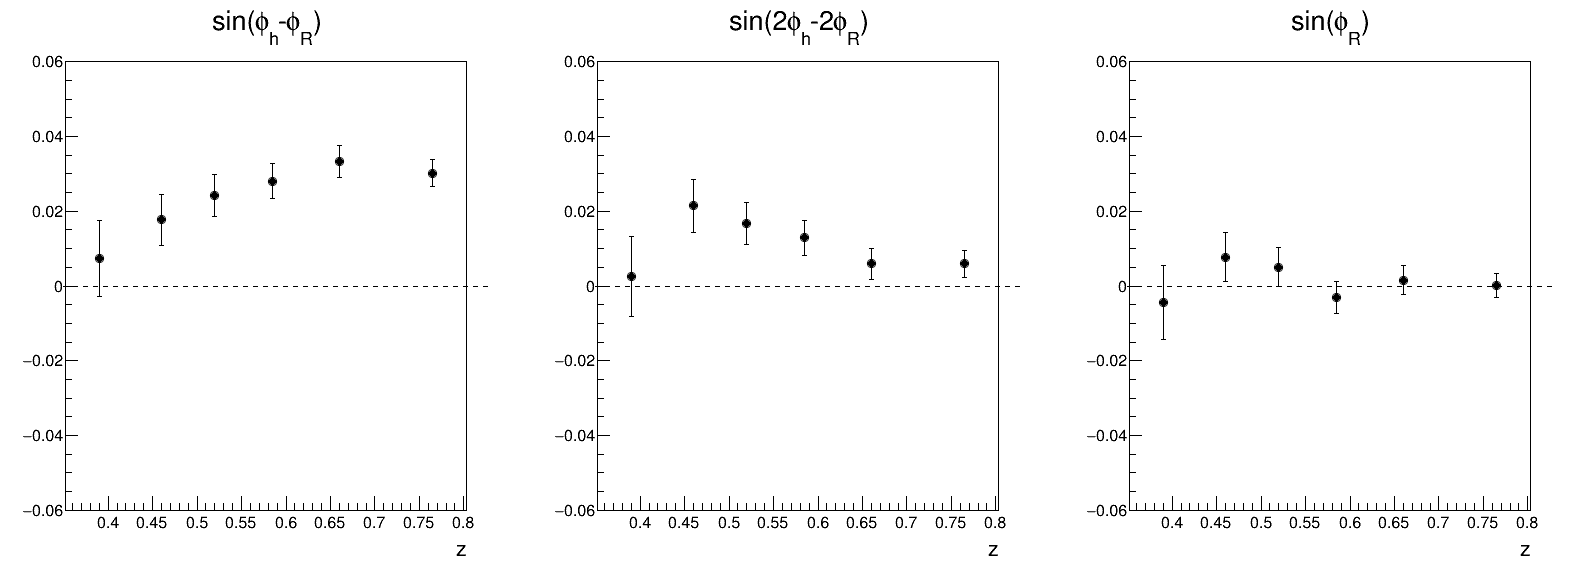

In [28]:
bins, fitpars_sig,errors_sig, u, plotstr = z_3c

idx_mods = [1,0,3]
ranges = [[-0.06,0.06],[-0.06,0.06],[-0.06,0.06]]

c = TCanvas("c","c",1600,600)
c.Divide(3,1)
tges_sig=get_asym_graph(bins,fitpars_sig,errors_sig,1,20,ranges,idx_mods,plotstr)

line=TLine(bins[0],0,bins[-1],0)
line.SetLineStyle(7)

for i in range(len(idx_mods)):
    c.cd(i+1)
    
    idx = idx_mods[i]
    modulation_name = mods[idx]
    tges_sig[i].Draw("APE same")
    
    line.Draw("same")
c.Draw()